In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px
from sklearn.model_selection import train_test_split

## Data Pre-processing

In [44]:
AAPL = pd.read_excel("./data/AAPL_EQUITY.xlsx")
SPESG = pd.read_excel(('./data/SPESG_Index_5Y.xlsx')).dropna()

# Take SPESG and AAPL and combine them into one data frame: df['Date', 'SPESG', 'AAPL_Px', 'AAPL_Volume', 'AAPL_SMAVG(15)']
df = pd.merge(AAPL, SPESG, on='Date', how='inner')
new_columns = {'Last Px_x' : 'AAPL_Px', 'Volume': 'AAPL_Volume(M)', 'SMAVG(15)' : 'AAPL_SMAVG15(M)', 'Last Px_y': 'SPESG'}
df.rename(columns=new_columns, inplace=True)

# Strip M and convert these columns from object into float64
df['AAPL_Volume(M)'] = df['AAPL_Volume(M)'].str.strip('M').astype('float64')
df['AAPL_SMAVG15(M)'] = df['AAPL_SMAVG15(M)'].str.strip('M').astype('float64')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.strftime('%A')

## Calculate returns

In [45]:
ret_period = [1, 5, 10, 30, 60, 120, 250]

for p in ret_period:
    df[f'AAPL_Px_ret{p}'] = ((df['AAPL_Px'] - df['AAPL_Px'].shift(-p)) / df['AAPL_Px'].shift(-p)).round(4)

df['AAPL_ret_f1'] = df['AAPL_Px_ret1'].shift(-1)
# Calculate the 100-day moving average
df['AAPL_Px_100MA'] = df['AAPL_Px'].shift(-100).rolling(window=100).mean()
df['AAPL_Px_50MA'] = df['AAPL_Px'].shift(-50).rolling(window=50).mean()
df['AAPL_Px_10MA'] = df['AAPL_Px'].shift(-10).rolling(window=10).mean()


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1274 non-null   datetime64[ns]
 1   AAPL_Px          1274 non-null   float64       
 2   AAPL_Volume(M)   1274 non-null   float64       
 3   AAPL_SMAVG15(M)  1260 non-null   float64       
 4   SPESG            1274 non-null   float64       
 5   Year             1274 non-null   int32         
 6   Quarter          1274 non-null   int32         
 7   Month            1274 non-null   int32         
 8   Day              1274 non-null   object        
 9   AAPL_Px_ret1     1273 non-null   float64       
 10  AAPL_Px_ret5     1269 non-null   float64       
 11  AAPL_Px_ret10    1264 non-null   float64       
 12  AAPL_Px_ret30    1244 non-null   float64       
 13  AAPL_Px_ret60    1214 non-null   float64       
 14  AAPL_Px_ret120   1154 non-null   float64

In [46]:
weekday_dummies = pd.get_dummies(df['Day']).astype(int)
df = pd.concat([df, weekday_dummies], axis=1)
df = df.dropna()
df.sort_values(by='Date', ascending=True, inplace=True)

X = df.drop(['Date', 'Day', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_Px_10MA']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# X_train.head()

# Feature Engineering

In [47]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

# Define a list of feature combinations to try
feature_combinations = [
    ['AAPL_Px'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'],
    ['Year', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    # Add more feature combinations as needed
]
regressor = RandomForestRegressor()
# Train and evaluate the model for each feature combination
for i, features in enumerate(feature_combinations):
    X_subset = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.4, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    print(f"Feature Combination {i + 1}: {features} - R-squared: {r_squared}")


Feature Combination 1: ['AAPL_Px'] - R-squared: 0.9582452014107088
Feature Combination 2: ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'] - R-squared: 0.8814050289317109
Feature Combination 3: ['Year', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] - R-squared: 0.9675944492619397


# Modeling
## Experimenting phase
### Linear Regression

In [48]:
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# regressor = linear_model.LinearRegression()
# regressor.fit(X_train, y_train)

# # Training set
# y_pred_train = regressor.predict(X_train)
# r2_train = r2_score(y_train, y_pred_train).round(4)

# # Test set
# y_pred_test = regressor.predict(X_test)
# r2_test = r2_score(y_test, y_pred_test).round(4)

# print(f"r2_train: {r2_train}")
# print(f"r2_test: {r2_test}")

# def adjusted_r2_score(r_squared, n, k):
#     return (1 - ((1 - r_squared) * (n - 1) / (n - k - 1))).round(4)

# n_samples = X_train.shape[0]
# n_features = X_train.shape[1]

# adj_r2_train = adjusted_r2_score(r2_train, n_samples, n_features)
# adj_r2 = adjusted_r2_score(r2_test, n_samples, n_features)
# print("Adjusted R-squared on Training Data:", adj_r2_train)
# print("Adjusted R-squared on Test Data:", adj_r2)

### Bayesian Regression

In [49]:
# from sklearn.linear_model import BayesianRidge
# from sklearn.metrics import mean_squared_error, r2_score

# # Create Bayesian Ridge regression object
# regressor = BayesianRidge()

# # Fit the model
# regressor.fit(X_train, y_train)

# # Predict on training set
# y_pred_train = regressor.predict(X_train)
# r2_train = r2_score(y_train, y_pred_train)

# # Predict on test set
# y_pred_test = regressor.predict(X_test)
# r2_test = r2_score(y_test, y_pred_test)

# print(f"r2_train: {r2_train}")
# print(f"r2_test: {r2_test}")

# # Function to calculate adjusted R^2
# def adjusted_r2_score(r_squared, n, k):
#     return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

# n_samples = X_train.shape[0]
# n_features = X_train.shape[1]

# adj_r2_train = adjusted_r2_score(r2_train, n_samples, n_features)
# adj_r2_test = adjusted_r2_score(r2_test, n_samples, n_features)
# print("Adjusted R-squared on Training Data:", adj_r2_train)
# print("Adjusted R-squared on Test Data:", adj_r2_test)


### Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Create Random Forest Regressor object
regressor = RandomForestRegressor()

cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Calculate mean and standard deviation of cross-validation scores
print("Mean R-squared:", cv_scores.mean())
print("Standard Deviation of R-squared:", cv_scores.std())

Cross-Validation Scores: [0.23367806 0.2174146  0.19744292 0.16206439 0.1677848 ]
Mean R-squared: 0.1956769538358243
Standard Deviation of R-squared: 0.027667687991870943


In [51]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
df_combined = pd.concat([X,y],axis=1)

SyntaxError: invalid syntax (3380097358.py, line 4)

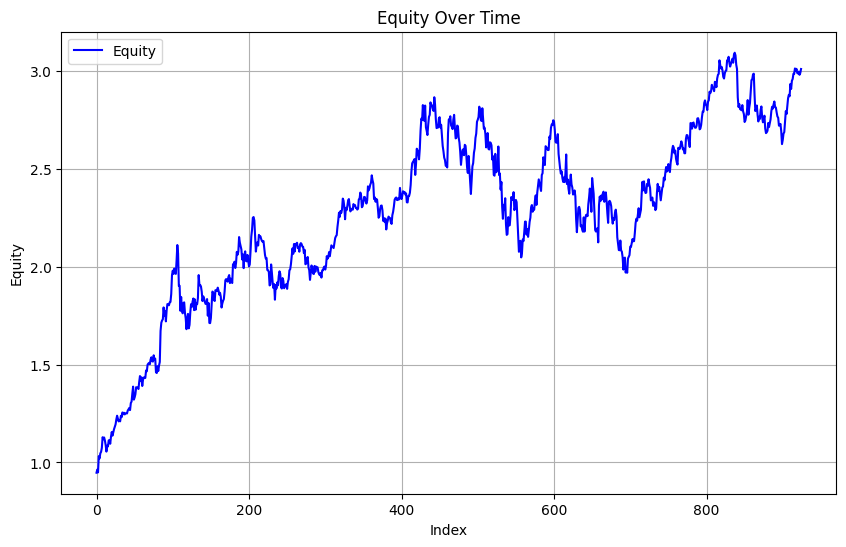

In [53]:
import pandas as pd

# Assuming df is your DataFrame containing AAPL one-day forward returns
# Assuming 'AAPL_ret_f1' is the column name for the one-day forward returns
df = df_combined
# Calculate cumulative returns
df['Cumulative_Returns'] = (1 + df['AAPL_ret_f1']).cumprod()

# Assuming initial equity is 1, you can adjust it according to your initial investment
initial_equity = 1

# Calculate equity based on cumulative returns
df['Equity'] = initial_equity * df['Cumulative_Returns']

# Print or display the DataFrame with equity

# Assuming df is your DataFrame containing time, AAPL one-day forward returns, and equity
# Replace 'Date' with the name of your time column if it's different
# Assuming 'AAPL_ret_f1' is the column name for the one-day forward returns
# Assuming 'Equity' is the column name for the equity


# Assuming df is your DataFrame containing AAPL one-day forward returns and equity
# Assuming 'Equity' is the column name for the equity

# Plot the graph
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(df.index, df['Equity'], label='Equity', color='blue')
plt.xlabel('Index')
plt.ylabel('Equity')
plt.title('Equity Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Sample DataFrame creation (you would use your actual DataFrame)
# data = pd.read_your_dataframe_here()

# Assuming risk-free rate is 2% annually
annual_risk_free_rate = 0.02
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/365) - 1

# Calculate average daily return and standard deviation
average_daily_return = df['AAPL_ret_f1'].mean()
std_dev_daily_returns = df['AAPL_ret_f1'].std()

# Calculate Sharpe Ratio
sharpe_ratio_daily = (average_daily_return - daily_risk_free_rate) / std_dev_daily_returns
sharpe_ratio_annual = sharpe_ratio_daily * (252**0.5)

print(f"Daily Sharpe Ratio: {sharpe_ratio_daily}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual}")


Daily Sharpe Ratio: 0.06877949987336085
Annualized Sharpe Ratio: 1.091840711785868


# Using moving averages and breakout system instead as the strategy!

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 925 entries, 1023 to 99
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AAPL_Px          925 non-null    float64
 1   AAPL_Volume(M)   925 non-null    float64
 2   AAPL_SMAVG15(M)  925 non-null    float64
 3   SPESG            925 non-null    float64
 4   Quarter          925 non-null    int32  
 5   Month            925 non-null    int32  
 6   AAPL_Px_ret1     925 non-null    float64
 7   AAPL_Px_ret5     925 non-null    float64
 8   AAPL_Px_ret10    925 non-null    float64
 9   AAPL_Px_ret30    925 non-null    float64
 10  AAPL_Px_ret60    925 non-null    float64
 11  AAPL_Px_ret120   925 non-null    float64
 12  AAPL_Px_ret250   925 non-null    float64
 13  AAPL_Px_100MA    925 non-null    float64
 14  AAPL_Px_50MA     925 non-null    float64
 15  AAPL_Px_10MA     925 non-null    float64
 16  Friday           925 non-null    int64  
 17  Monday           92